In [2]:
import os
import sys

# Add the parent directory of the current script and 'src' folder to the path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from src.model_unet import *

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load your saved data
test_data = torch.load("../data/prepared_datasets/train_flowers.pt")
test_labels = torch.load("../data/prepared_datasets/train_flowers_labels.pt")
val_data = torch.load("../data/prepared_datasets/val_flowers.pt")
val_labels = torch.load("../data/prepared_datasets/val_flowers_labels.pt")
train_data = torch.load("../data/prepared_datasets/test_flowers.pt")
train_labels = torch.load("../data/prepared_datasets/test_flowers_labels.pt")

In [3]:
train_data.shape

torch.Size([6149, 3, 64, 64])

In [4]:
batch_size = 32

In [5]:
def prepare_data_loaders(train_data, train_labels, val_data, val_labels, test_data, test_labels, batch_size=batch_size):
    train_dataset = TensorDataset(train_data, train_labels)
    val_dataset = TensorDataset(val_data, val_labels)
    test_dataset = TensorDataset(test_data, test_labels)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    return train_loader, val_loader, test_loader

In [6]:
# Normalize data to [0, 1] if not already done
train_data = (train_data - train_data.min()) / (train_data.max() - train_data.min())
val_data = (val_data - val_data.min()) / (val_data.max() - val_data.min())
test_data = (test_data - test_data.min()) / (test_data.max() - test_data.min())

train_data = train_data * 2 - 1
val_data = val_data * 2 - 1
test_data = test_data * 2 - 1
# Create data loaders
train_loader, val_loader, test_loader = prepare_data_loaders(train_data, train_labels, val_data, val_labels, test_data, test_labels)

In [8]:
from torch.optim import Adam
from torch.optim import AdamW

image_size = 64
channels = 3

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
model.to(device)

#optimizer = Adam(model.parameters(), lr=5e-3)
#optimizer = AdamW(model.parameters(), lr=5e-3)
optimizer = Adam(model.parameters(), lr=1e-3)

cuda


In [9]:
timesteps = 200
betas = DiffusionSchedule.linear_beta_schedule(timesteps).clone()
diffusion_params = DiffusionSchedule.compute_diffusion_parameters(betas)

In [17]:
from torchvision.utils import save_image

epochs = 20
for epoch in range(epochs):
    for batch_idx, (data, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")):
        data = data.to(device)
        optimizer.zero_grad()

        #batch_size = batch["pixel_values"].shape[0]
        #batch = batch["pixel_values"].to(device)

        # Algorithm 1 line 3: sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()
        if data.shape[0] == batch_size:
            
            loss = p_losses(model, data, t, loss_type="huber", diffusion_params=diffusion_params)
            
            if batch_idx % 100 == 0:
                print("Loss:", loss.item())
            
            loss.backward()
            optimizer.step()

Epoch 1/20:   1%|          | 1/193 [00:00<01:24,  2.28it/s]

Loss: 0.04947102069854736


Epoch 1/20:  52%|█████▏    | 101/193 [00:15<00:13,  6.68it/s]

Loss: 0.05582088977098465


Epoch 2/20:   1%|          | 1/193 [00:00<00:28,  6.83it/s]

Loss: 0.048244278877973557


Epoch 2/20:  52%|█████▏    | 101/193 [00:15<00:13,  6.58it/s]

Loss: 0.030174029991030693


Epoch 3/20:   1%|          | 1/193 [00:00<00:28,  6.85it/s]

Loss: 0.028010083362460136


Epoch 3/20:  52%|█████▏    | 101/193 [00:14<00:13,  6.96it/s]

Loss: 0.04022488743066788


Epoch 4/20:   1%|          | 1/193 [00:00<00:27,  6.92it/s]

Loss: 0.05462567135691643


Epoch 4/20:  52%|█████▏    | 101/193 [00:15<00:13,  6.99it/s]

Loss: 0.07049329578876495


Epoch 5/20:   1%|          | 1/193 [00:00<00:27,  6.92it/s]

Loss: 0.06145188957452774


Epoch 5/20:  52%|█████▏    | 101/193 [00:14<00:13,  6.75it/s]

Loss: 0.03022439405322075


Epoch 6/20:   1%|          | 1/193 [00:00<00:26,  7.29it/s]

Loss: 0.037543125450611115


Epoch 6/20:  52%|█████▏    | 101/193 [00:14<00:13,  6.99it/s]

Loss: 0.062792107462883


Epoch 7/20:   1%|          | 1/193 [00:00<00:27,  6.92it/s]

Loss: 0.025400448590517044


Epoch 7/20:  52%|█████▏    | 101/193 [00:15<00:13,  6.72it/s]

Loss: 0.04296959564089775


Epoch 8/20:   1%|          | 1/193 [00:00<00:27,  6.97it/s]

Loss: 0.023733358830213547


Epoch 8/20:  52%|█████▏    | 101/193 [00:15<00:13,  6.58it/s]

Loss: 0.02922471985220909


Epoch 9/20:   1%|          | 1/193 [00:00<00:28,  6.65it/s]

Loss: 0.030278993770480156


Epoch 9/20:  52%|█████▏    | 101/193 [00:15<00:14,  6.50it/s]

Loss: 0.04146415740251541


Epoch 10/20:   1%|          | 1/193 [00:00<00:27,  6.97it/s]

Loss: 0.04745548591017723


Epoch 10/20:  52%|█████▏    | 101/193 [00:15<00:13,  6.83it/s]

Loss: 0.04064695164561272


Epoch 11/20:   1%|          | 1/193 [00:00<00:30,  6.28it/s]

Loss: 0.027152668684720993


Epoch 11/20:  52%|█████▏    | 101/193 [00:15<00:13,  6.73it/s]

Loss: 0.05761308595538139


Epoch 12/20:   1%|          | 1/193 [00:00<00:26,  7.18it/s]

Loss: 0.02808155119419098


Epoch 12/20:  52%|█████▏    | 101/193 [00:15<00:13,  6.75it/s]

Loss: 0.033043116331100464


Epoch 13/20:   1%|          | 1/193 [00:00<00:29,  6.60it/s]

Loss: 0.045012544840574265


Epoch 13/20:  52%|█████▏    | 101/193 [00:15<00:13,  6.57it/s]

Loss: 0.030343038961291313


Epoch 14/20:   1%|          | 1/193 [00:00<00:27,  6.86it/s]

Loss: 0.040176037698984146


Epoch 14/20:  52%|█████▏    | 101/193 [00:14<00:13,  6.91it/s]

Loss: 0.04068097472190857


Epoch 15/20:   1%|          | 1/193 [00:00<00:28,  6.63it/s]

Loss: 0.04144970327615738


Epoch 15/20:  52%|█████▏    | 101/193 [00:14<00:13,  6.60it/s]

Loss: 0.028032395988702774


Epoch 16/20:   1%|          | 1/193 [00:00<00:28,  6.63it/s]

Loss: 0.042697273194789886


Epoch 16/20:  52%|█████▏    | 101/193 [00:14<00:12,  7.13it/s]

Loss: 0.021661799401044846


Epoch 17/20:   1%|          | 1/193 [00:00<00:30,  6.33it/s]

Loss: 0.03038390539586544


Epoch 17/20:  52%|█████▏    | 101/193 [00:15<00:13,  7.02it/s]

Loss: 0.03549579903483391


Epoch 18/20:   1%|          | 1/193 [00:00<00:28,  6.79it/s]

Loss: 0.0302834864705801


Epoch 18/20:  52%|█████▏    | 101/193 [00:14<00:13,  6.89it/s]

Loss: 0.03742286562919617


Epoch 19/20:   1%|          | 1/193 [00:00<00:28,  6.85it/s]

Loss: 0.06407191604375839


Epoch 19/20:  52%|█████▏    | 101/193 [00:14<00:13,  7.03it/s]

Loss: 0.03774537891149521


Epoch 20/20:   1%|          | 1/193 [00:00<00:27,  7.08it/s]

Loss: 0.03953051194548607


Epoch 20/20:  52%|█████▏    | 101/193 [00:14<00:13,  6.88it/s]

Loss: 0.036674462258815765


Epoch 20/20: 100%|██████████| 193/193 [00:28<00:00,  6.89it/s]


In [36]:
torch.save({
    'epoch': epochs,
    'batch_size':batch_size,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
}, 'model_3.pth')

In [37]:
model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
checkpoint = torch.load('model_3.pth')
state_dict = checkpoint['model_state_dict']
model.load_state_dict(state_dict)

model = model.to(device)

In [38]:
print(image_size,channels)
samples = sample(model, image_size=image_size, batch_size=batch_size, channels=channels, diffusion_params=diffusion_params)

64 3


sampling loop time step: 100%|██████████| 200/200 [00:09<00:00, 20.90it/s]


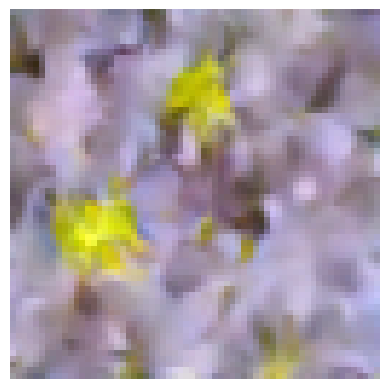

In [42]:
import numpy as np
img = samples[-1][3]
img = img.cpu().numpy()
img = np.transpose(img, (1, 2, 0))
img = (img - img.min()) / (img.max() - img.min())
plt.imshow(img)
plt.axis('off')  # Hide axis
#plt.imsave("saved_image.png", img)
plt.show()

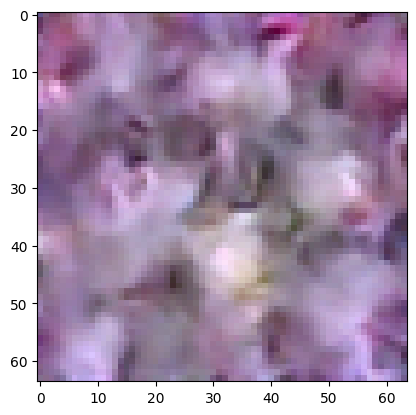

In [20]:
random_index = 3
plt.imshow(img.reshape(image_size, image_size, channels))

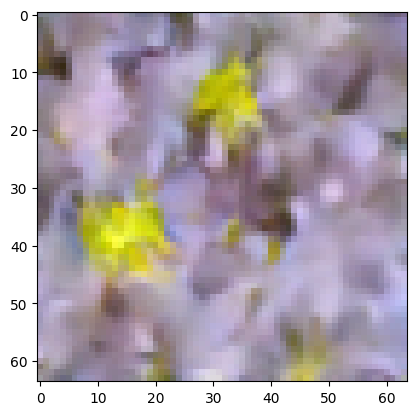

In [40]:
import matplotlib.animation as animation

random_index = 3

fig = plt.figure()
ims = []
#print(samples[2][0].shape)
for i in range(timesteps):
    img = samples[i][random_index]
    img = img.cpu().numpy()
    img = np.transpose(img, (1, 2, 0)) 
    #img = samples[i][random_index].reshape(image_size, image_size, channels)
    img = (img - img.min()) / (img.max() - img.min())
    im = plt.imshow(img, animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
#animate.save('diffusion.gif')
plt.show()

In [18]:
timesteps

200